# Create Time Series Graph Database

POD Time Series Graph | Project 3
Goal: Create Time Series graph database for different Investment Pods owned by a HedgeFund.

Nodes: Investment_Pod and Pod_Trading_Day
Relationship:  Trading_Day, Next_Day
Labels:  Pod_id, date, weekly_return 

Steps
- Before running this notebook, the following notebooks need to have been run in order:
    - 1_Data_Wrangling_Extract_Workbook.ipynb
    - 2_Data_Wrangling_Load_CSV.ipynb
    - 2_1_Data_Wrangling_Create_Pod_Return_From_NAV_History.ipynb

- Setup Cursors and connection to Containers
- Use the Data Loaded in Postgres Table "temp_pod_ret_history" to create  node (Investment_Pod) with label pod_id   connected by relation (Trading_Day) to node (PodTradingDay) with label date and weekly_return. 
- Create Linked List between  Pod_Trading_Day nodes using apoc.nodes.link procedure. 
- Collect the  weekly_returns by days and store as a list property of each investment_pod  node.
- View Graph in Neo4j Browser

In [1]:
import neo4j

import csv

import math
import numpy as np
import pandas as pd

import psycopg2

In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [3]:
session = driver.session(database="neo4j")

## Setup Cursors and Connection

In [4]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [5]:
cursor = connection.cursor()

In [6]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [7]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [8]:
def my_neo4j_number_nodes_relationships():
    "print the number of nodes and relationships"
   
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    print("-------------------------")
    print("  Nodes:", number_nodes)
    print("  Relationships:", number_relationships)
    print("-------------------------")

# Custom Functions for our Database

In [9]:
def my_neo4j_create_pod_and_trading_day_nodes(date, pod_id, weekly_return):
    """Create  node (Investment_Pod) with label pod_id connected by relation (Trading_Day) 
        to node (PodTradingDay) with label date and weekly_return
    """
    
    query = """
    
    MERGE (s:Investment_Pod{name:$pod_id})
    CREATE (s)-[:TRADING_DAY]->(:PodTradingDay{date:date($date), weekly_return:($weekly_return)});
   
    """

    session.run(query, date=date, pod_id=pod_id, weekly_return=weekly_return)

In [10]:
def my_neo4j_create_trading_day_linked_list():
    """For each investment_pod, create trading day linked list 
    and store weekly_returns as attribute for each investment_pod.
    """
    
    query = """

    MATCH (s:Investment_Pod)-[:TRADING_DAY]->(day)
    WITH s, day
    ORDER BY day.date ASC
    WITH s, collect(day) as nodes, collect(day.weekly_return) as returns
    SET s.return_array = returns
    WITH nodes
    CALL apoc.nodes.link(nodes, 'NEXT_DAY')
    RETURN distinct 'done' AS result

    """
    session.run(query)

## Wipe out Neo4j database

In [11]:
my_neo4j_wipe_out_database()

## Check number of nodes and relationships

In [12]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 0
  Relationships: 0
-------------------------


In [13]:
"""Read data from table temp_pod_ret_history to create  node (Investment_Pod) with label pod_id connected by relation (Trading_Day) 
        to node (PodTradingDay) with label date and weekly_return.
    Note: we have restricted date to use only 5 years of data due to resource limitation.
"""


connection.rollback()


query = """

select date, pod_id, return
from temp_pod_ret_history
where date > '2019-12-31'
order by pod_id, date

"""

cursor.execute(query)

connection.rollback()

rows = cursor.fetchall()
counter = len(rows)
print("Number of rows returned=", counter)
for row in rows:
    
    date =  row[0]
    pod_id = row[1]
    weekly_return = float(row[2])
    my_neo4j_create_pod_and_trading_day_nodes(date, pod_id, weekly_return)

Number of rows returned= 6336


In [14]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 6358
  Relationships: 6336
-------------------------


There are 22 Investment_Pods and each has weekly returns - in total 6336 trading days from 01-01-2020 to 07-04-2025. 
(6336 + 22 = 6358)

### Showing the Investment_Pod (name: 0431214C JP and ASLAX US)  with their Trading Day nodes from 01-01-2020 to 07-04-2025 .  This image is captured from Neo4J Browser using the follwoing query:

match (n) return n

NOTE: Not all return nodes are being displayed due to Initial Node Display setting. Only first 300 nodes are displayed. 


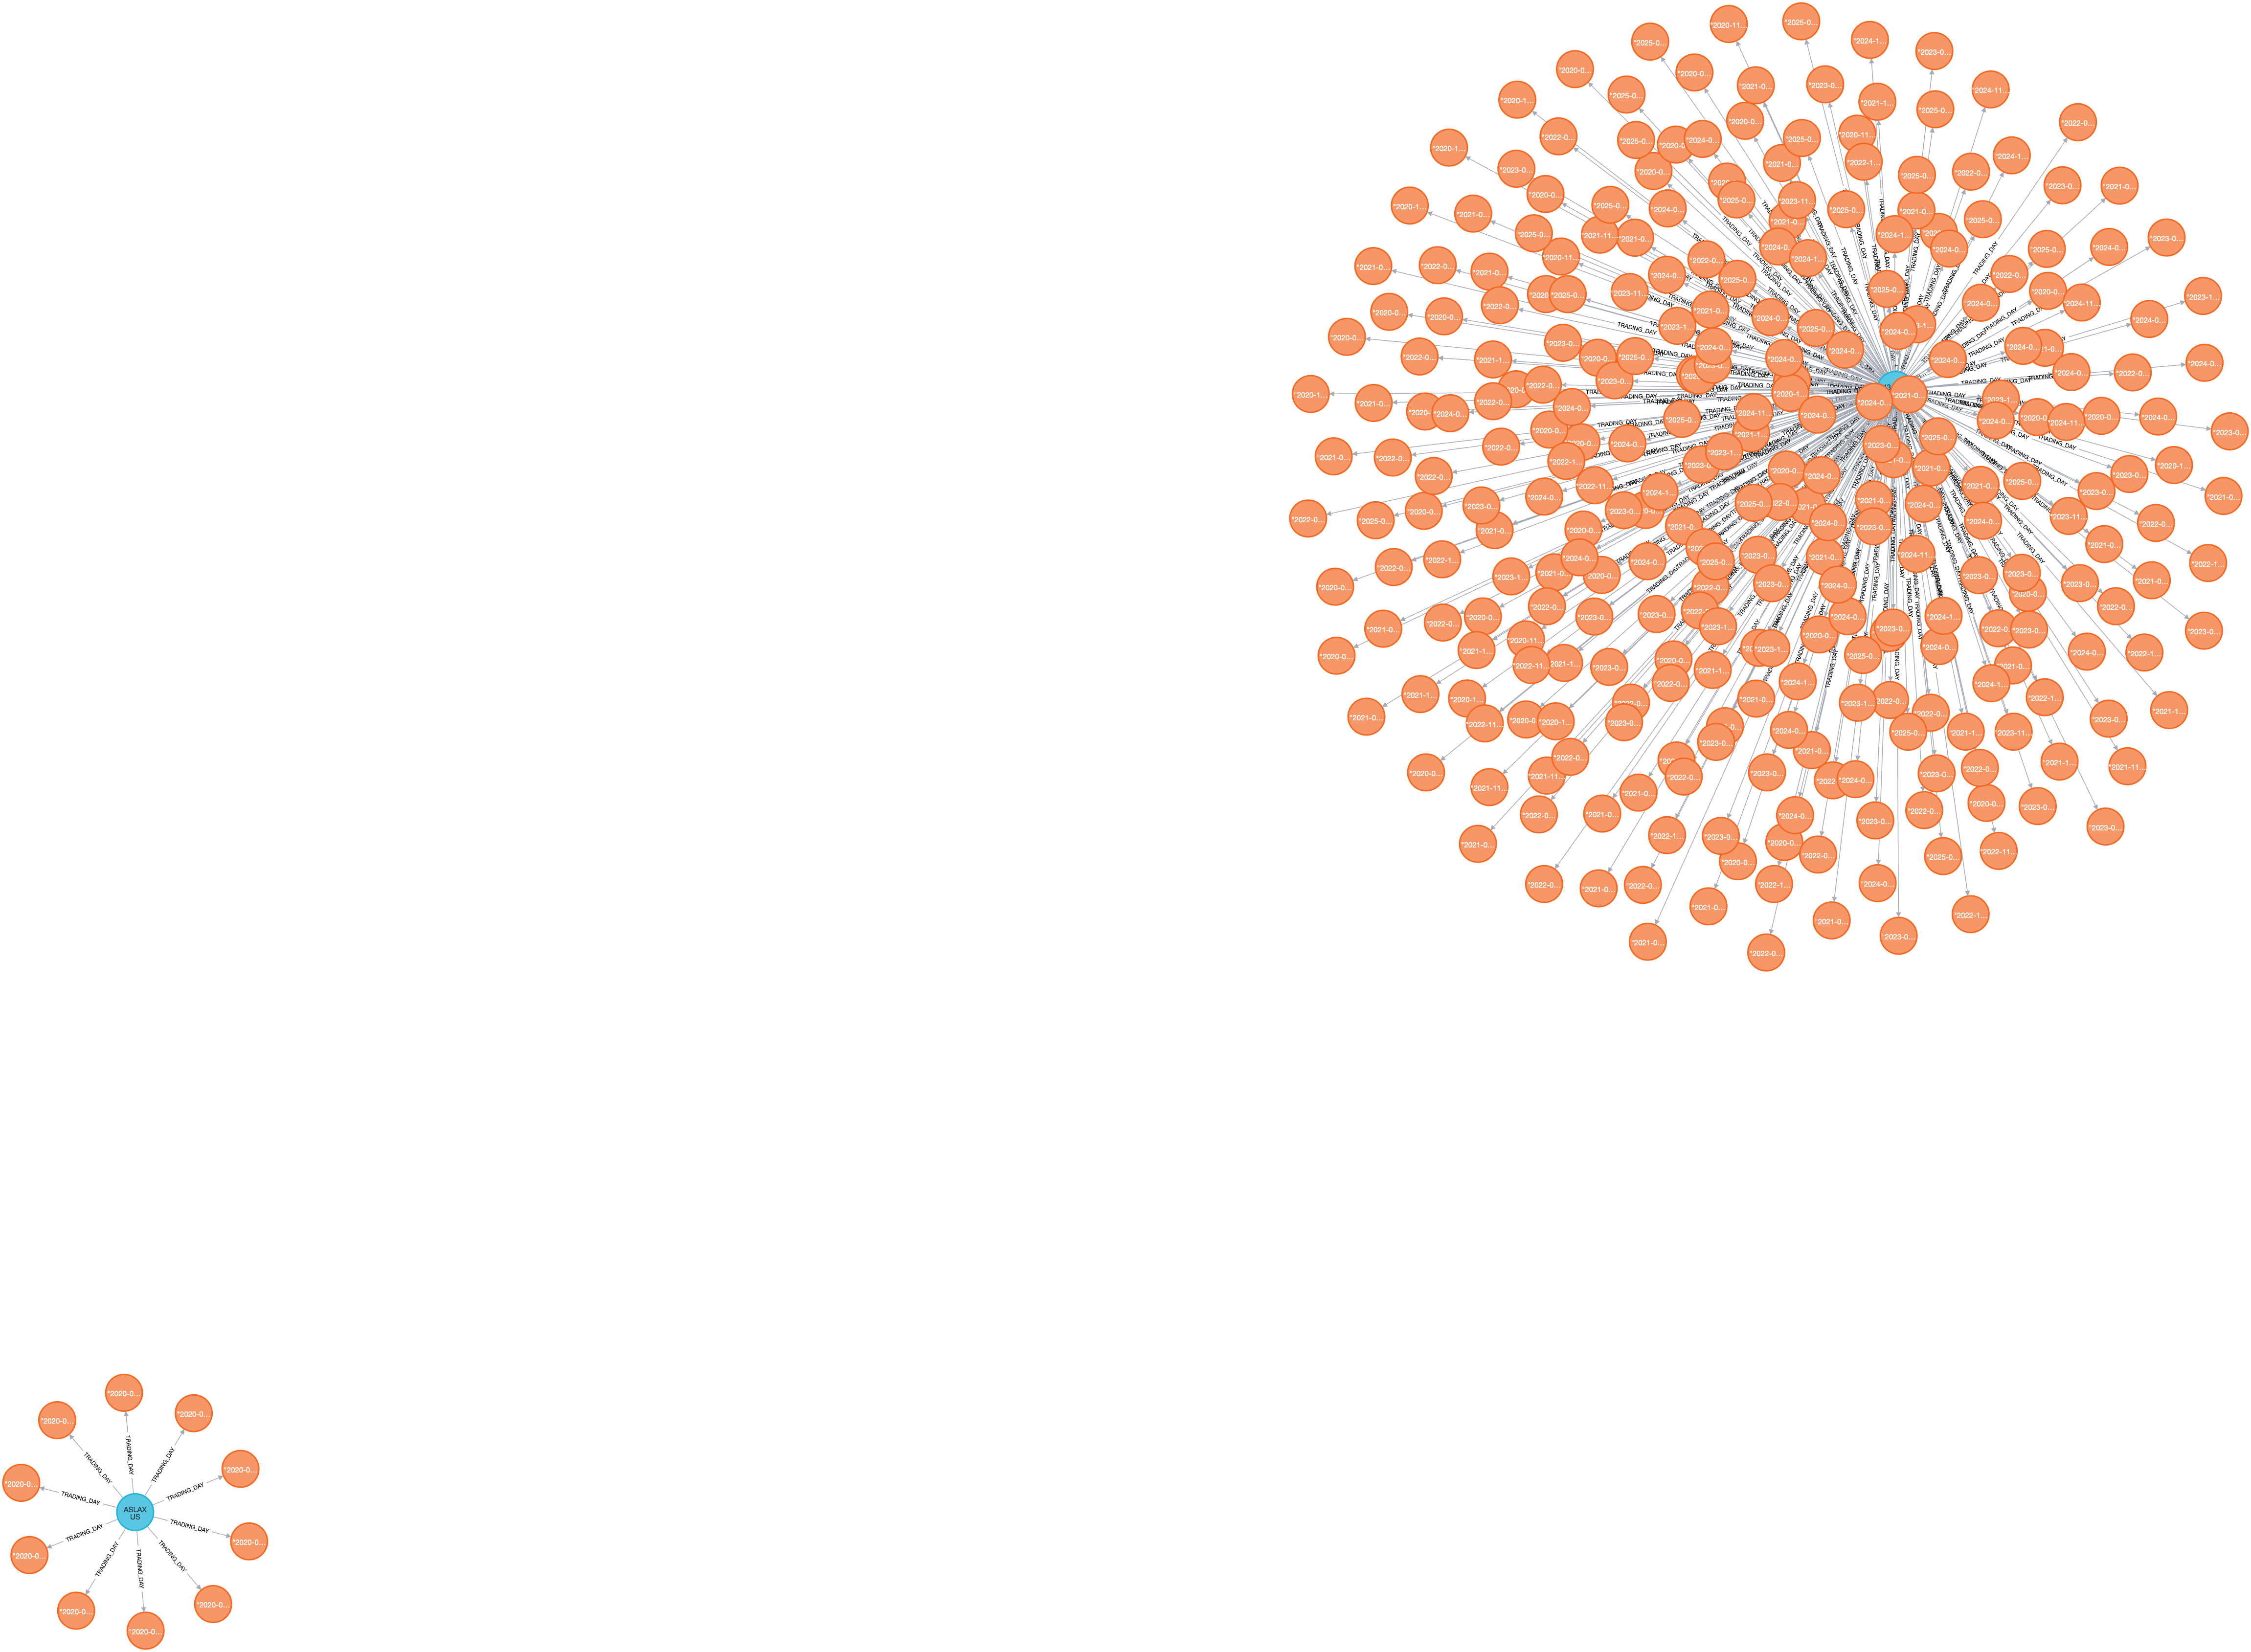

## Next, we need to create a linked list between pod_trading_day nodes using apoc.nodes.link procedure. We will also collect the  weekly_returns by days and store as a list property of each investment_pod node. 

In [16]:
my_neo4j_create_trading_day_linked_list()


In [17]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 6358
  Relationships: 18964
-------------------------


## Image showing the linked list for the investment_pod (name: 0431214C JP and name: ASLAX US). 
This image is captured from the Neo4j Browser using the following query:
match (n) return n



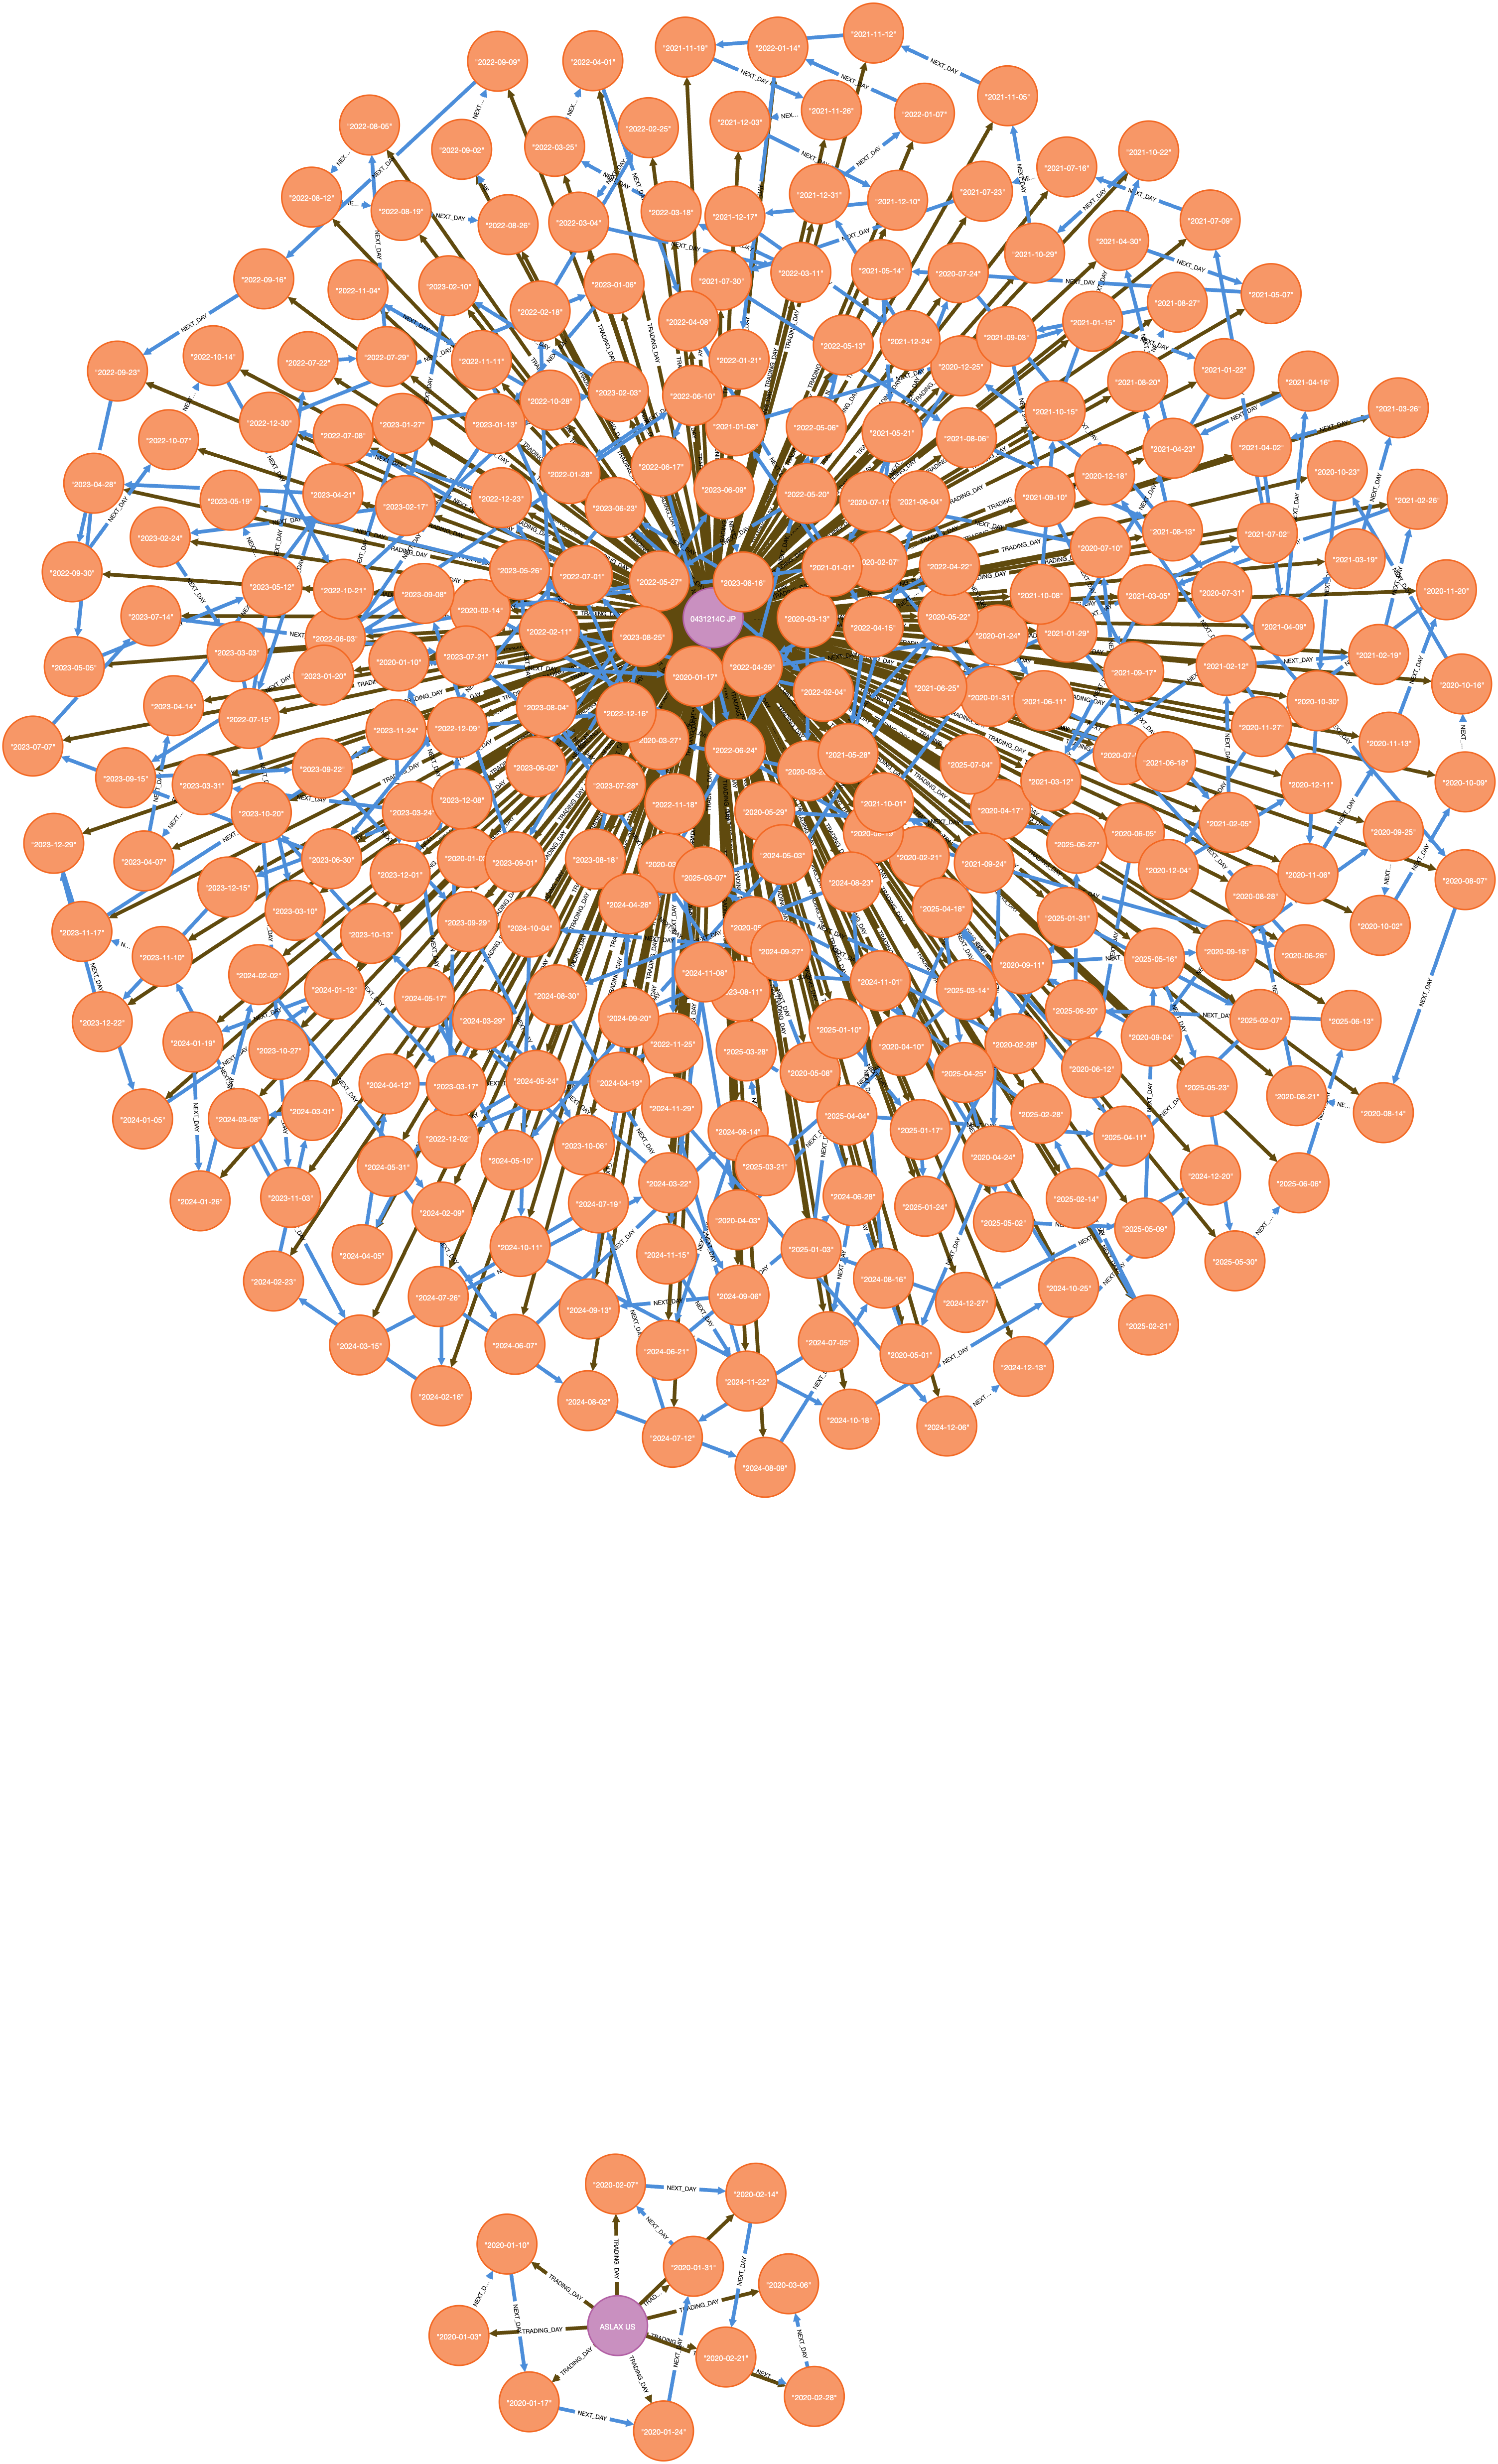